Import necessary packages.

In [55]:
import json
import spacy
from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import re

In [2]:
import logging, sys
logging.disable(sys.maxsize) # do not display log info

Load NLP pipeline for english text analysis.

In [43]:
nlp = spacy.load('en_core_web_sm')

Import texts.

Texts are saved into two dictionaries:
- texts_dict, which holds the texts by title: abstract
- corpora_by_year, which holds the texts by year: list of abstracts

In [62]:
files = [
    'papers-semeval-2021.json',
    'papers-semeval-2022.json',
    'papers-semeval-2023.json',
    'papers-semeval-2024.json'
]

texts_dict = dict()
corpora_by_year = dict()

for filename in files:
    with open(filename, 'r', encoding='utf-8') as f:
        data = json.load(f)
        year = filename[15:19]
        corpora_by_year[year] = []
        for item in data:
            texts_dict[item['title']] = item['abstract']
            corpora_by_year[year].append(item['abstract'])

For topics processing, extract noun lemmas from abstracts and save them to lemmas_dict.

In [44]:
lemmas_dict = dict()
for text_name, text_content in texts_dict.items():
    doc = nlp(text_content)
    noun_lemmas = [
        token.lemma_ for token in doc
        if token.pos_ in ["NOUN", "PROPN"] and token.is_alpha
    ]
    lemmas_dict[text_name] = ' '.join(noun_lemmas)

Define functions for LSA analysis.

In [15]:
def prepare_corpus(cleaned_docs):
    dictionary = corpora.Dictionary(cleaned_docs)

    doc_term_matrix = [dictionary.doc2bow(doc) for doc in cleaned_docs]

    return dictionary, doc_term_matrix

def create_gensim_lsa_model(lemmas, number_of_topics):
    
    cleaned_docs = [lemmas_string.split() for lemmas_string in lemmas]
    dictionary, doc_term_matrix = prepare_corpus(cleaned_docs)
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    
    return lsamodel

def find_topics(lsamodel, NUM_TOPICS, NUM_WORDS_IN_TOPICS):
    topics = lsamodel.print_topics(num_topics=NUM_TOPICS, num_words=NUM_WORDS_IN_TOPICS)
    topic_nr = -1
    topic_list = []
    for topic in topics:
        topic_nr += 1
        topic_list.append(topic)
    return topic_list

def find_topics_LSA(lemmas, NUM_TOPICS, NUM_WORDS_IN_TOPICS):
    lsa_model = create_gensim_lsa_model(lemmas, number_of_topics = NUM_TOPICS)
    topic_list = find_topics(lsa_model, NUM_TOPICS, NUM_WORDS_IN_TOPICS)
    return topic_list

Define functions for coherence score analysis to determine the optimal amount of topics on the corpus.

In [28]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(docs, start, stop, step):
    cleaned_docs = [doc_string.split() for doc_string in docs]
    dictionary,doc_term_matrix = prepare_corpus(cleaned_docs)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix, cleaned_docs,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

start,stop,step=2,13,1

Perform coherence score analysis on the corpus.

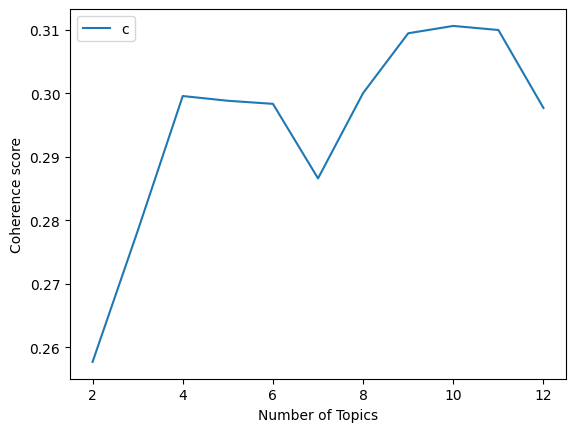

In [46]:
plot_graph(lemmas_dict.values(), start, stop, step)

From the graph, we see that 10 topics is the optimal amount of topics from the range 2-12 topics. So we pick 10 topics as the local optimum here.

Perform LSA on the whole corpus (the whole 4 years). Find 10 topics, 6 words in each topic.

In [58]:
topics_lsa = find_topics_LSA(lemmas_dict.values(), 10, 6)

pattern = r'"([^"]+)"'

topics = []
for topic in topics_lsa:
    topics.append(re.findall(pattern, topic[1]))

for topic in topics:
    print(topic)

['model', 'task', 'system', 'language', 'paper', 'text']
['task', 'model', 'language', 'sub', 'datum', 'text']
['system', 'subtask', 'model', 'text', 'task', 'Task']
['language', 'model', 'text', 'system', 'sentiment', 'English']
['subtask', 'system', 'word', 'entity', 'text', 'language']
['text', 'system', 'language', 'approach', 'model', 'image']
['approach', 'text', 'language', 'system', 'emotion', 'Task']
['word', 'subtask', 'Task', 'context', 'sentence', 'detection']
['datum', 'Task', 'word', 'training', 'domain', 'score']
['datum', 'emotion', 'entity', 'word', 'approach', 'technique']


Based on the topics (list of nouns), we calculate IDF scores for each word in each topic by year.

The word IDF scores are then aggregated on the topic level, giving us aggregated IDF scores per topic per year.

Those results are then plotted.

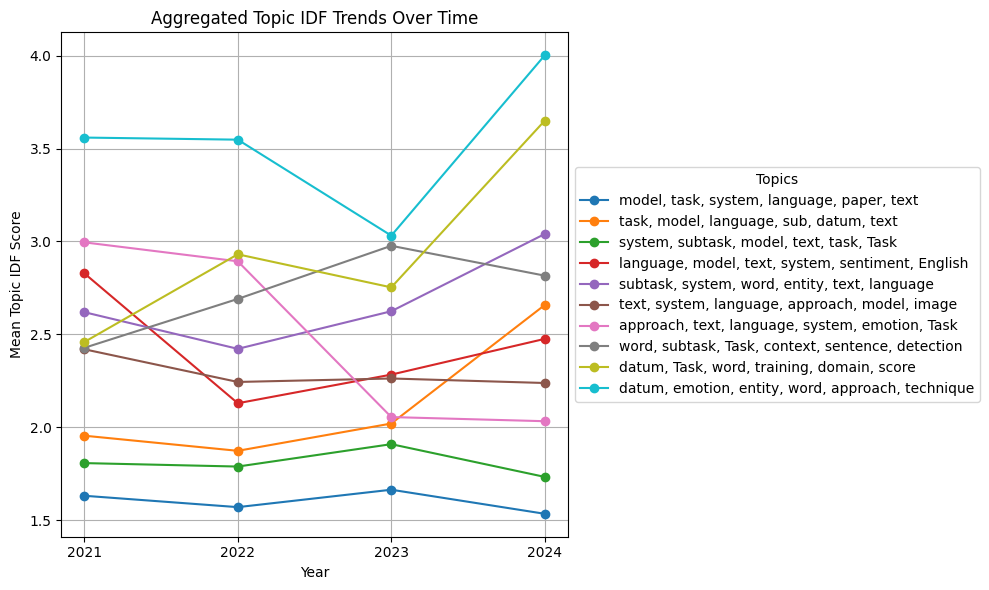

In [63]:
# Compute year-wise IDF
year_idf_scores = {}
for year, docs in corpora_by_year.items():
    vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    vectorizer.fit(docs)
    vocab = vectorizer.vocabulary_
    idf_values = vectorizer.idf_
    idf_dict = {word: idf_values[idx] for word, idx in vocab.items()}
    year_idf_scores[year] = idf_dict

years = sorted(corpora_by_year.keys())

# Aggregate IDFs by topic
topic_aggregated_idfs = []
for topic_words in topics:
    topic_idf_by_year = []
    for yr in years:
        word_idfs = [year_idf_scores[yr][w] for w in topic_words if w in year_idf_scores[yr]]
        mean_idf = sum(word_idfs)/len(word_idfs) if word_idfs else None
        topic_idf_by_year.append(mean_idf)
    topic_aggregated_idfs.append(topic_idf_by_year)

# Plot all topics on one graph
plt.figure(figsize=(10, 6))
for topic_words, y in zip(topics, topic_aggregated_idfs):
    plt.plot(years, y, marker='o', label=', '.join(topic_words))

plt.title("Aggregated Topic IDF Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Mean Topic IDF Score")
plt.grid(True)

# Place legend on the right side of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Topics")

plt.tight_layout()
plt.show()